<a href="https://colab.research.google.com/github/chettkulkarni/MachineLearning/blob/master/ML_Final/ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ML Final Collab for Fake News Detection

Brief Outline of the this collab :


1.   Liar Liar Dataset : Trying to classify News into 6 classes from fake to truth 
2.   Amalgamating a factor called **Stance** using Sem2Eval and fakenews dataset and then tried to predict fakeness
3.   Distillation : **LDA** on liar liar dataset and calculated LDA score and using this new data tried to predict fakeness
4.   Distillation 2 : Performed **sentiment analysis** and using this new data tried to predict fakeness
5.   Distillation 3: Performed **Named entity relation** and using this new data tried to predict fakeness
6.   After above steps, had many dimensions, Performed **PCA** and then tried to predict fakeness
7.  BERT Transformer
8.   Using only top features using GINI
9.   Combined with other features from other team memebers : Political Affiliation  ,Title Vs Body , Network Factor
10. Conclusion



## Prediction on base Liar Liar Dataset

importing all the libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
!pip install nltk
!pip install gensim
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install tf-hub-nightly
!pip install sentencepiece





import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import urllib
import zipfile
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.externals import joblib 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.naive_bayes import MultinomialNB


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score


% matplotlib inline




In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Downloading dataset

In [0]:
link = ' https://drive.google.com/open?id=1y3yYF5HHPhH7SyaPwPU9H5HApJzevsFK'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar.zip')

import zipfile
with zipfile.ZipFile('liar.zip', 'r') as zip_ref:
    zip_ref.extractall()

liar_train = pd.read_csv('train.tsv', sep='\t',header=None)
liar_train=liar_train.drop(columns=[0])

columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state info',
'party affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar_train.columns=columns

liar_train.head()

label  ...              context
0  false        ...  a mailer           
1  half-true    ...  a floor speech.    
2  mostly-true  ...  Denver             
3  false        ...  a news release     
4  half-true    ...  an interview on CNN

[5 rows x 13 columns]

In [0]:
liar_test = pd.read_csv('test.tsv', sep='\t',header=None)
liar_test=liar_test.drop(columns=[0])

columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state info',
'party affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar_test.columns=columns

In [0]:
liar=pd.concat([liar_train,liar_test])

**Final Datset looks like below**

In [0]:
liar

label  ...                                 context
0     false        ...  a mailer                              
1     half-true    ...  a floor speech.                       
2     mostly-true  ...  Denver                                
3     false        ...  a news release                        
4     half-true    ...  an interview on CNN                   
...         ...    ...                  ...                   
1262  half-true    ...  a news conference                     
1263  barely-true  ...  on ABC's "This Week"                  
1264  barely-true  ...  a commentary in The Providence Journal
1265  barely-true  ...  a news conference                     
1266  false        ...  an interview with NJToday             

[11507 rows x 13 columns]

### Label Encoding 

In [0]:
le=LabelEncoder()

In [0]:
le_speaker=LabelEncoder()
le_speaker_job_title_code=LabelEncoder()
le_state_info_code=LabelEncoder()
le_speaker_job_title=LabelEncoder()


le_speaker.fit(liar['speaker'].astype(str))
le_speaker_job_title_code.fit(liar['speaker_job_title'].astype(str))
le_state_info_code.fit(liar['state info'].astype(str))
le_speaker_job_title.fit(liar['speaker_job_title'].astype(str))



liar['speaker_code']=le.fit_transform(liar['speaker'].astype(str))
liar['speaker_job_title_code']=le.fit_transform(liar['speaker_job_title'].astype(str))
liar['state info_code']=le.fit_transform(liar['state info'].astype(str))
liar['label_code']=le.fit_transform(liar['label'].astype(str))


In [0]:
liar_clean=liar[['barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','label_code']]

In [0]:
liar_clean

barely_true_counts  false_counts  ...  speaker_job_title_code  label_code
0     0.0                 1.0           ...  930                     1         
1     0.0                 0.0           ...  928                     2         
2     70.0                71.0          ...  686                     3         
3     7.0                 19.0          ...  1179                    1         
4     15.0                9.0           ...  1179                    2         
...    ...                ...           ...   ...                   ..         
1262  28.0                23.0          ...  425                     2         
1263  2.0                 0.0           ...  425                     0         
1264  1.0                 0.0           ...  1234                    0         
1265  9.0                 8.0           ...  429                     0         
1266  1.0                 1.0           ...  1179                    1         

[11507 rows x 9 columns]

In [0]:
liar_clean.label_code.value_counts()

2    2379
1    2244
3    2203
5    1884
0    1866
4    931 
Name: label_code, dtype: int64

In [0]:
corr=liar_clean.corr()

### Plotting corelation between features

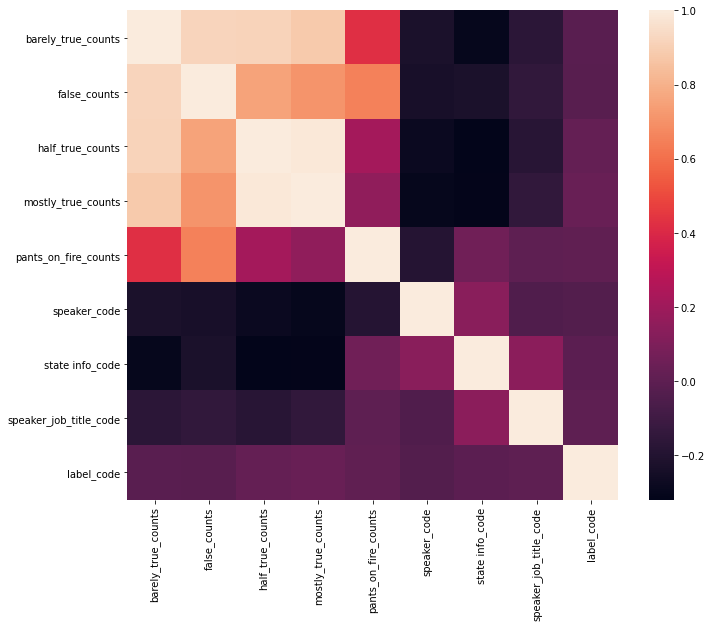

In [0]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr)

### Creating an automl type of code to run various models on our dataset

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)*100





def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
  accuracy={}
  specificity={}
  sensitivity={}
  roc_auc={}
  model_save=None
  i=0
  #models_dict holds name and its function , like {'LR':LogsticRegression()}
  for name,model in models_dict.items():
      #fitting model on the train data
      model.fit(X_train,y_train)
      joblib.dump(model, name+'.pkl')
      #predicting model on X_test 
      model_save=model
      y_pred=model.predict(X_test)
      print('*'*100)
      print('Model:',name)
      #printing Confusion matrix an dAccuracy of each model
      print("Confusion Matrix: ")
      print(confusion_matrix(y_test, y_pred))
      print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

      #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
      accuracy[name]=accuracy_score(y_test,y_pred)*100
      cm=confusion_matrix(y_test, y_pred)

      roc_auc[name]=multiclass_roc_auc_score(y_test, y_pred)
      sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
      specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
      print("Classificarion Report : ")
      print(classification_report(y_test, y_pred))
      
  
  #converting dictionaries to dataframes to have them handy
  accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
  sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
  specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
  roc_auc=pd.DataFrame.from_dict(roc_auc,orient='index').reset_index()
  # print(accuracy)
  accuracy.columns=['model_name','accuracy']
  sensitivity.columns=['model_name','sensitivity']
  specificity.columns=['model_name','specificity']
  roc_auc.columns=['model_name','roc_auc_score']
  
  #plotting accuracy,sensitivity,specificity of each model
  plt.figure(i+1,figsize=(16, 6))
  ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
  ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
  ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
  ax = sns.lineplot(data=roc_auc, x='model_name', y='roc_auc_score',legend='full')
  ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
  plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ,Red: ROC_AUC_SCORE')
  return model_save

In [0]:
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)

### Using Gini Plotting the importance of each feature

In [0]:
dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_

array([0.18950664, 0.14458035, 0.15120294, 0.09269852, 0.1177953 ,
       0.14603695, 0.07277663, 0.08540268])

In [0]:
importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
importance

feature_name  importance
0  barely_true_counts      0.189507  
1  false_counts            0.144580  
2  half_true_counts        0.151203  
3  mostly_true_counts      0.092699  
4  pants_on_fire_counts    0.117795  
5  speaker_code            0.146037  
6  state info_code         0.072777  
7  speaker_job_title_code  0.085403

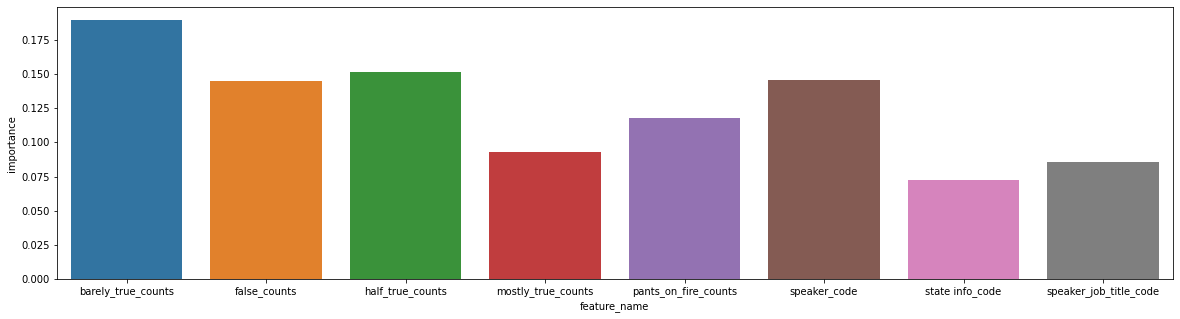

In [0]:
plt.figure(figsize=(20,5))
sns.barplot(importance.feature_name,importance.importance);

**After initial Run , it is evident that all the columns are useful in some way and barely true counts,half true counts and speaker are the top 3 features in the current dataset**

In [0]:
models_dict={}
# models_dict['LinearRegression']       = LinearRegression()
models_dict['LogisticRegression']     = LogisticRegression()
models_dict['Dtree']                  = DecisionTreeClassifier()
models_dict['NB']                     = GaussianNB()
models_dict['XGB']                    = XGBClassifier()
models_dict['RForest']                = RandomForestClassifier()
models_dict['SVM']                    = SVC(gamma='auto')
models_dict['KNN']                    = KNeighborsClassifier()


****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 411 255 428  11   0]
 [  5 611 246 449  37   0]
 [  1 406 432 624   6   0]
 [  0 305 314 656   8   0]
 [  2 266  94 135  72   0]
 [  1 304 277 537   8   0]]
Accuracy :  25.706010137581465
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.31      0.00      0.01      1109
           1       0.27      0.45      0.33      1348
           2       0.27      0.29      0.28      1469
           3       0.23      0.51      0.32      1283
           4       0.51      0.13      0.20       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.26      6905
   macro avg       0.26      0.23      0.19      6905
weighted avg       0.24      0.26      0.20      6905

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

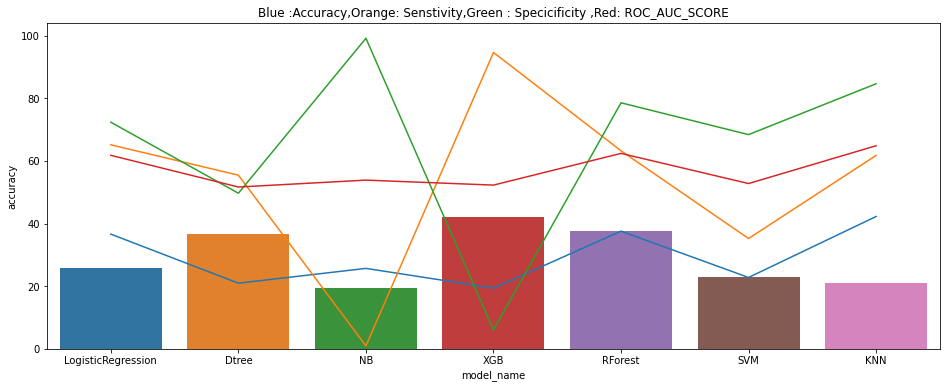

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

**After running all the algorithms on initial dataset XGP performs the best with almost 40% accuracy for 6 classes**

# Deriving *Stance* Feature

### Idea

The whole idea of stance detection is based on following prediction



```


1.   Similar Statements tend to have Similar Stance 
2.   TF-IDF of words in statements can help us identify stance


```



### Approach

1. Get All the data from both the datasets
2. Remove the unwanted columns 
3. Remove Digits
4. Perform Stemming the words
5. Remove Stop Words
6. Remove Punctuation marks
7. Update the Stance of SemEval Dataset to the following values
    *  'AGAINST' to 1
    *  'FAVOR' to 2
    *  'NONE' to 0
8. Update the Stance of FakeNewsChallenge Datset to the following  values
    * 'unrelated' to 0
    * 'disagree' to 1
    * 'agree' to 2
    * 'discuss' to 3
9. Combine Both the dataset
10. Create Tagged Document
11. Create a doc2Vec Model
12. Check the accuracy
13. Run other Models like NaiveBayes, LR,KNN,Dtree,Rforest,SVM,KNN
14. Compare the model performances
15. Use the best model to classify the stance in the liar liar dataset




Downloading dataset of fake news

In [0]:
link = ' https://drive.google.com/open?id=1R92GzZsujQFyCYGCWY45zeE5G4KKVhGR'
fluff, id = link.split('=')


#Download the file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('stance-detection.zip')

#unzip the downloaded file
with zipfile.ZipFile('stance-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

#read the file and store it in dataframe called fake , this is the data set found from fake news challenge website
fake_train=pd.read_csv('train_merged.csv',encoding='latin-1')
fake_train=fake_train.drop(columns=['Body ID','Headline' ])
fake_train=fake_train.drop_duplicates()


fake_test=pd.read_csv('test_merged.csv',encoding='latin-1')
fake_test=fake_test.drop(columns=['Body ID','Headline' ])
fake_test=fake_test.drop_duplicates()

In [0]:
fake=pd.concat([fake_train,fake_test])

In [0]:
#seeing some of the records
fake.head()

articleBody     Stance
0   A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \r\nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\r\n\r\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\r\n\r\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\r\n\r\n"We have to study it more because it could be ice or rock," he said.\r\n\r\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was "very strange that no one reported a streak of light. We have to ask if anyone has a photo or something."\r\n\r\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\r\n\r\n"I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave," Jorge Santamaria told The Associated Press.\r\n\r\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.  unrelated
24  A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \r\n\r\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \r\nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\r\n\r\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\r\n\r\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\r\n\r\n"We have to study it more because it could be ice or rock," he said.\r\n\r\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was "very strange that no one reported a streak of light. We have to ask if anyone has a photo or something."\r\n\r\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\r\n\r\n"I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave," Jorge Santamaria told The Associated Press.\r\n\r\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.  agree    
36  Last week we hinted at what was to 

Also downloading dataset fromsem2Eval datset

In [0]:
#downloading the file from sem2eval and unzipping and loading it into df

url='http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip'
urllib.request.urlretrieve(url, 'stancedataset.zip')

with zipfile.ZipFile('stancedataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

df_train=pd.read_csv('StanceDataset/train.csv', sep=',',header=0, error_bad_lines=False,encoding= 'unicode_escape',engine='python')
df_train=df_train[['Tweet','Stance']]

df_test=pd.read_csv('StanceDataset/train.csv', sep=',',header=0, error_bad_lines=False,encoding= 'unicode_escape',engine='python')
df_test=df_test[['Tweet','Stance']]

In [0]:
df=pd.concat([df_train,df_test])

In [0]:
#defining a set of stop_words, we will be dropping these stop words because they dont give any value to our analysis
stop_words = set(stopwords.words('english')) 

Performing Data cleaning activities like 


1.   removing special characters
2.   removing numbers
3.   removing stop words
4.   converting full statement to lower case 
5.   word tokenisation



In [0]:
# removing punctation ,special characters and digits and converting all the text to lowe and then work_tokenizing them and storing it in a column called CleanTweet
df['CleanTweet'] = df['Tweet'].map(lambda x: re.sub(r"\W", " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: re.sub(r" \d+", " ",str(x)))
df['CleanTweet'] = df['CleanTweet'].map(lambda x: word_tokenize(x.lower()))

df['CleanTweet'] = df['CleanTweet'].map(lambda x: ' '.join(x))
df['CleanTweet'] = df['CleanTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [0]:
df.head()

Tweet  ...                                                                                               CleanTweet
0  @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot  ...  tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot
1  Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio                                        ...  hillary best choice truly want continue progressive nation ohio                                        
2  @TheView I think our country is ready for a female pres, it can't ever be Hillary                                                ...  theview think country ready female pres ever hillary                                                   
3  I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary     ...  gave unhealthy amount hard earned money away big gov untrustworthy irs whyimnotvotingforhillary        
4  @PortiaABoulger Thank you for adding me to your list                                                                             ...  portiaaboulger thank adding list                                                                       

[5 rows x 3 columns]

Defining different stance class numbers

In [0]:
#A function to create numbers for stances
def stacneIt(s):
  if s=='AGAINST':
    return 1
  elif s=='FAVOR':
    return 2
  else:
    return 0

df['Stance_Number']=df['Stance'].map(lambda x: stacneIt(x))

### Word cloud for words in a news with differnt types of stance 

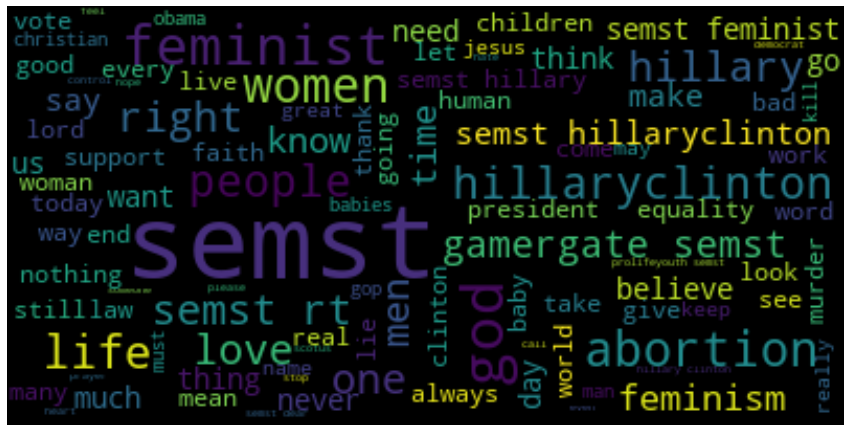

In [0]:
text=' '.join(df[df['Stance']=='AGAINST'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

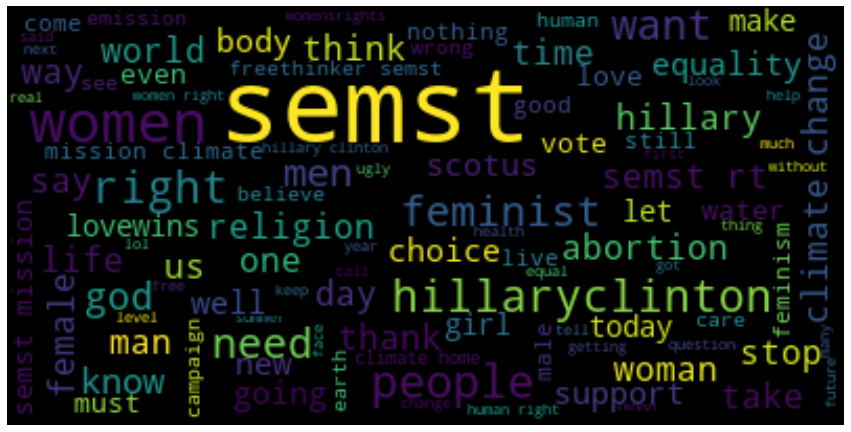

In [0]:
text=' '.join(df[df['Stance']=='FAVOR'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

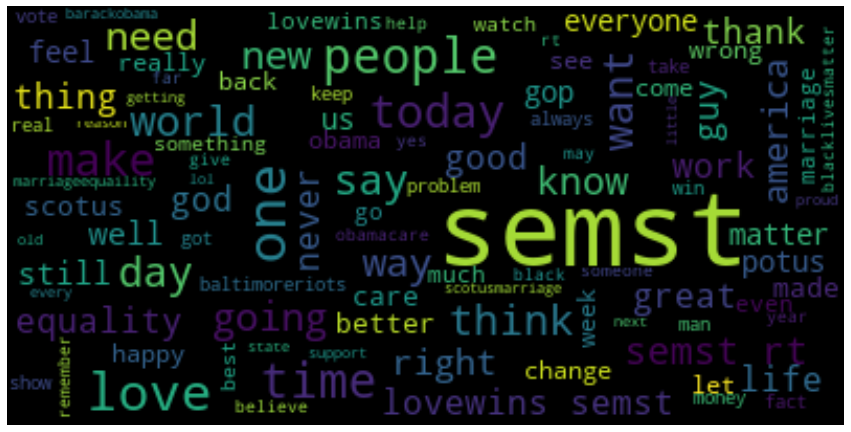

In [0]:
text=' '.join(df[df['Stance']=='NONE'].CleanTweet)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
fake['cleanedArticle'] = fake['articleBody'].map(lambda x: re.sub(r"\W", " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: re.sub(r" \d+", " ",str(x)))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: word_tokenize(x.lower()))
fake['cleanedArticle'] = fake['cleanedArticle'].map(lambda x: ' '.join(x))
fake['cleanedArticle'] = fake['cleanedArticle'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [0]:
def getStance(s):
  if s=='agree':
    return 1
  elif s=='disagree':
    return 2
  # elif s=='discuss':
  #   return 3
  else:
    return 0

In [0]:
fake['Stance_Number']=fake['Stance'].map(lambda x: getStance(x))

In [0]:
fake=fake.drop_duplicates()

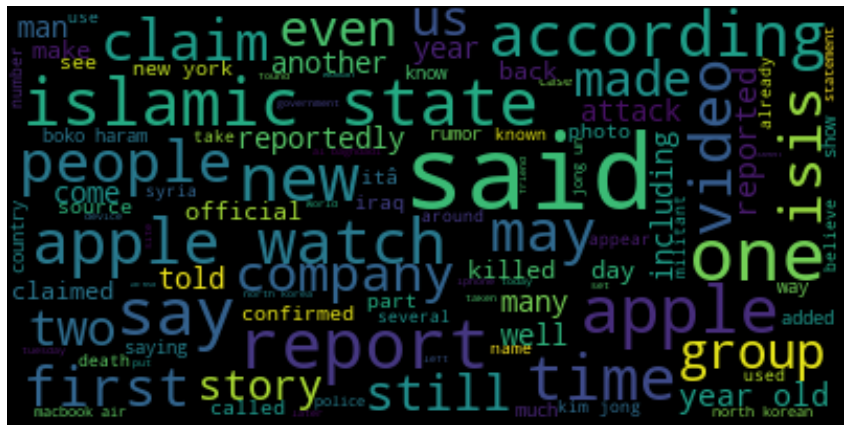

In [0]:
text=' '.join(fake[fake['Stance']=='discuss'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

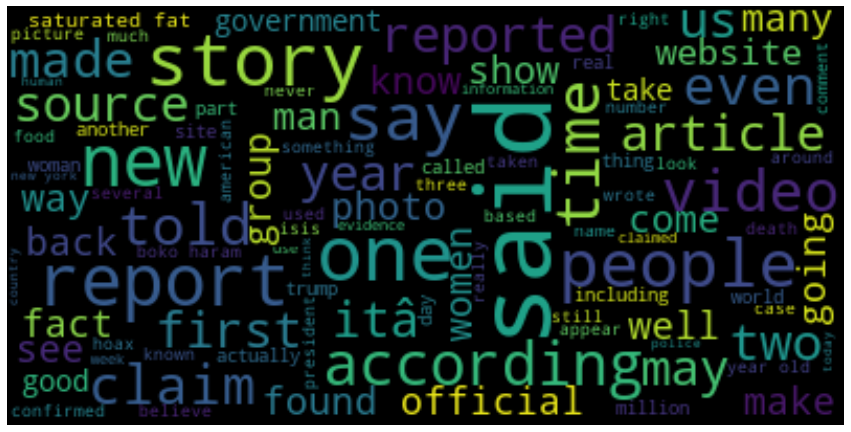

In [0]:
text=' '.join(fake[fake['Stance']=='disagree'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

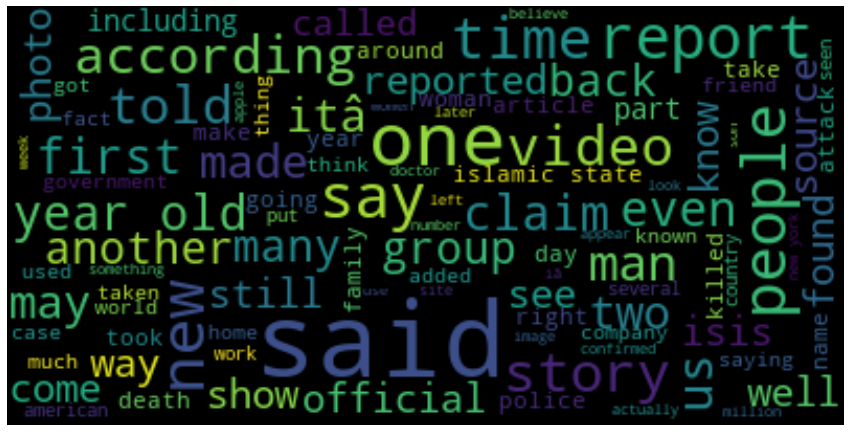

In [0]:
text=' '.join(fake[fake['Stance']=='agree'].cleanedArticle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
 df1=df[['CleanTweet','Stance_Number']]
 df1.columns=['statement','stance']
 df2=fake[['cleanedArticle','Stance_Number']]
 df2.columns=['statement','stance']

In [0]:
final=pd.concat([df1,df2])

In [0]:
final.iloc[0]

statement    tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot
stance       1                                                                                                      
Name: 0, dtype: object

In [0]:
#combined dataset looks like 
final.head()

statement  stance
0  tedcruz handovertheserver wiped clean k deleted emails explains dereliction duty lies benghazi etc tcot  1     
1  hillary best choice truly want continue progressive nation ohio                                          2     
2  theview think country ready female pres ever hillary                                                     1     
3  gave unhealthy amount hard earned money away big gov untrustworthy irs whyimnotvotingforhillary          1     
4  portiaaboulger thank adding list                                                                         0

In [0]:
X=final['statement']
Y=final['stance']

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.10, random_state=42)

In [0]:
tagged_data = [TaggedDocument(words=article.split(),tags=[str(index)]) for index, article in enumerate(X_train)]
tagged_data_test = [TaggedDocument(words=article.split(),tags=[str(index)]) for index, article in enumerate(X_test)]

### Creating doc2vec model
This model will take the tagged data and will be used on the liar data to find stance of that document

In [0]:
model = Doc2Vec(alpha=.025, min_alpha=.025, min_count=1, workers = 5)
model.build_vocab(tagged_data)
model.train(tagged_data,total_examples=model.corpus_count,epochs=model.iter)

In [0]:
def get_simialrity_model_test(statemnt):
  test = re.sub(r"\W", " ",str(statemnt))
  test =re.sub(r'[,\.!?]', " ",str(test))
  test = re.sub(r" \d+", " ",str(test))
  test= word_tokenize(test.lower())
  infered_vector = model.infer_vector(test)
  doc_number , similarity_percentage = model.docvecs.most_similar([infered_vector], topn = 1)[0]
  return final.iloc[int(doc_number)]['stance']

In [0]:
X_test=pd.DataFrame(X_test)
X_test['stance'] = X_test['statement'].apply(lambda x: get_simialrity_model_test(x))

In [0]:
accuracy_score(X_test.stance,Y_test)

0.3926325247079964

**40 % accuracy for 3 types is kinda low*

In [0]:
len(Y_test)

1113

In [0]:
# create the transform
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(final['statement'])

X = vectorizer.transform(final['statement'])
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [0]:
final.iloc[0]
X[0]

<1x33941 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

### Using TFIDF and trying to predict stance using various algorithms

In [0]:
models_dict={}
models_dict['LogisticRegression']       = LogisticRegression()
models_dict['Dtree']                    = DecisionTreeClassifier()
models_dict['NB']                       = MultinomialNB()
models_dict['RForest']                  = RandomForestClassifier()
models_dict['SVM']                      = SVC(gamma='auto')
models_dict['KNN']                      = KNeighborsClassifier()

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[652  92   4]
 [160 437  13]
 [ 84  67 160]]
Accuracy :  74.83523067705212
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       748
           1       0.73      0.72      0.72       610
           2       0.90      0.51      0.66       311

    accuracy                           0.75      1669
   macro avg       0.79      0.70      0.72      1669
weighted avg       0.76      0.75      0.74      1669

****************************************************************************************************
Model: Dtree
Confusion Matrix: 
[[641 102   5]
 [168 414  28]
 [ 78  21 212]]
Accuracy :  75.91372079089275
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.72      0.86      0.78       748
           1       0.77      

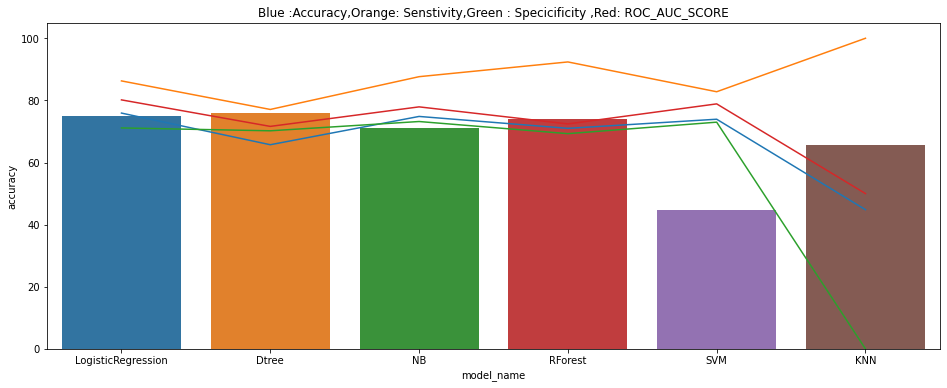

In [0]:
X
Y=final.loc[:,final.columns=='stance']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)
model_save=fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

**As seen above almost every model is performing in similar way , but Rforest is slightly performing better in terms of sensitivity and specificity .Hence will be using this model to predict stance**

In [0]:
vector=joblib.load('vectorizer.pkl')
loaded_model=joblib.load('RForest.pkl')

### Amalgamating Sem2Eval and FakeNews dataset with Liar Liar Dataset

Stance is a factor devised using the data from fakenews and sem2eval dataset

In [0]:
liar['cleanedStatement'] = liar['statement'].map(lambda x: re.sub(r"\W", " ",str(x)))
liar['cleanedStatement'] = liar['cleanedStatement'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
liar['cleanedStatement'] = liar['cleanedStatement'].map(lambda x: re.sub(r" \d+", " ",str(x)))
liar['cleanedStatement'] = liar['cleanedStatement'].map(lambda x: word_tokenize(x.lower()))
liar['cleanedStatement'] = liar['cleanedStatement'].map(lambda x: ' '.join(x))
liar['cleanedStatement'] = liar['cleanedStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [0]:
liar_x = vector.transform(liar['cleanedStatement'])
liar_stance=loaded_model.predict(liar_x)
liar['stance']=liar_stance

liar=liar.drop(columns=['cleanedStatement'])

In [0]:
liar_stances_1=liar[liar.stance==1]
liar_stances_2=liar[liar.stance==2]
liar_stances_0=liar[liar.stance==0]

Word cloud on liar liar dataset with different stances

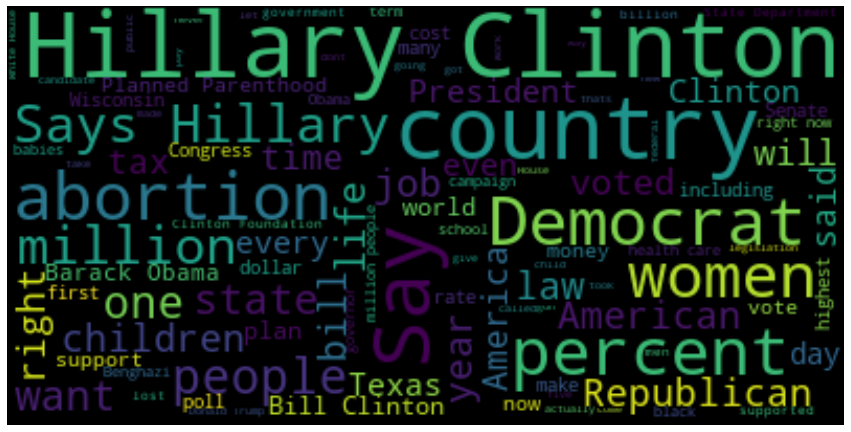

In [0]:
text=' '.join(liar_stances_1.statement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

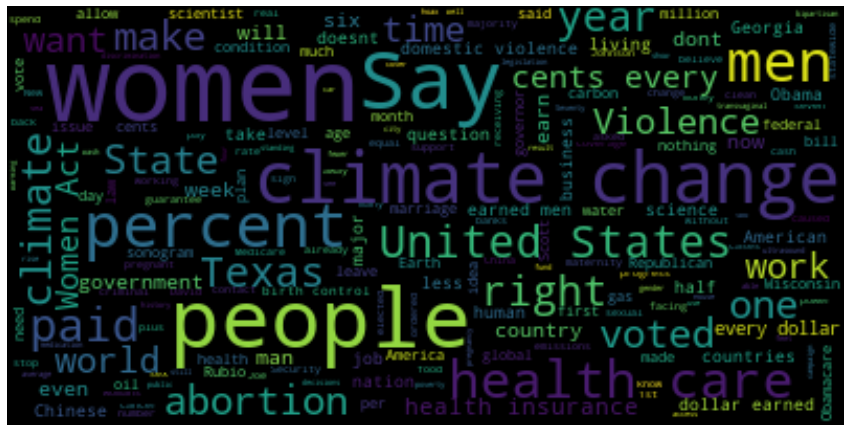

In [0]:
text=' '.join(liar_stances_2.statement)
wordcloud = WordCloud(max_font_size=50, background_color="black").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

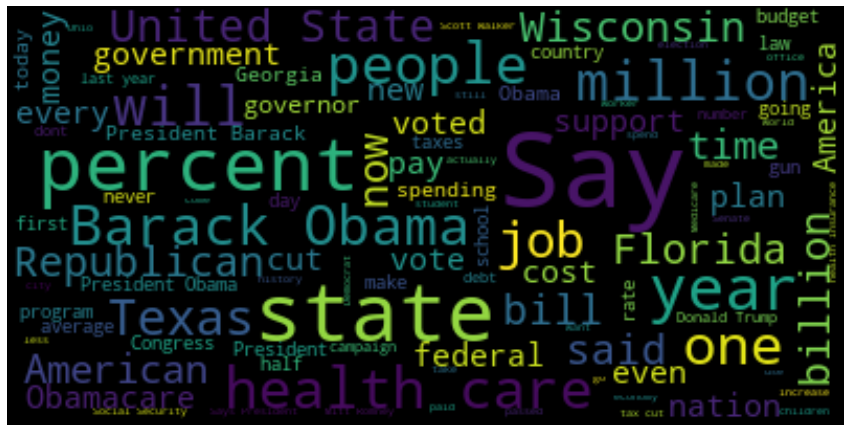

In [0]:
text=' '.join(liar_stances_0.statement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
liar

label  ... stance
0     false        ...  0    
1     half-true    ...  0    
2     mostly-true  ...  1    
3     false        ...  0    
4     half-true    ...  0    
...         ...    ... ..    
1262  half-true    ...  0    
1263  barely-true  ...  0    
1264  barely-true  ...  0    
1265  barely-true  ...  0    
1266  false        ...  0    

[11507 rows x 18 columns]

### Running models to predict fakeness



1.   Checking the gini score to get importance of each factor towards fakeness
2.   Perforiming ML models to predict fakeness



In [0]:
liar_clean=liar[['barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','stance','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)

In [0]:
dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_

array([0.18373132, 0.13535198, 0.1356514 , 0.08821012, 0.1104443 ,
       0.1329935 , 0.07266142, 0.07636553, 0.06459043])

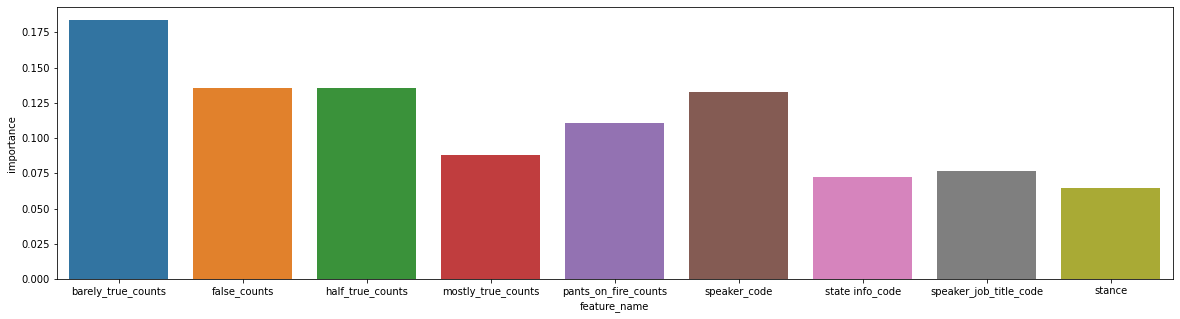

In [0]:
importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(20,5))
sns.barplot(importance.feature_name,importance.importance);

It can be clearly seen that stance when added to the dataset, it is giving 5% gini score of importance towards predicting fakeness

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 434 243 417  11   0]
 [  5 657 222 427  37   0]
 [  1 418 431 613   6   0]
 [  0 321 303 651   8   0]
 [  2 282  83 130  72   0]
 [  1 332 259 527   8   0]]
Accuracy :  26.28530050687907
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.31      0.00      0.01      1109
           1       0.27      0.49      0.35      1348
           2       0.28      0.29      0.29      1469
           3       0.24      0.51      0.32      1283
           4       0.51      0.13      0.20       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.26      6905
   macro avg       0.27      0.24      0.19      6905
weighted avg       0.25      0.26      0.21      6905

*********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

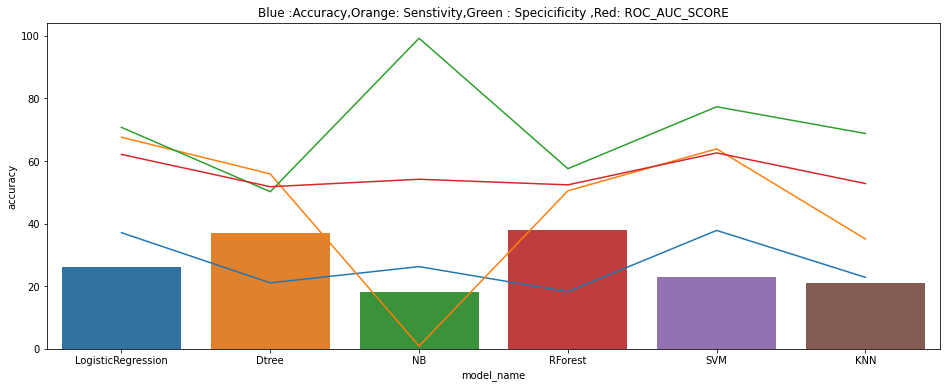

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

After Getting Stance into the dataset , the predicttion has increased to 40% using Rforest. Which is a sligth increase in the accuracy

# Performing Distillation1 : LDA

In [0]:

stop_words = set(stopwords.words('english'))
liar.dropna()
liar['CleanStatement'] = liar['statement'].map(lambda x: re.sub(r"\W", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r" \d+", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: word_tokenize(x.lower()))

liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: ' '.join(x))
liar['CleanStatement'] = liar['CleanStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [0]:
count_vectorizer = CountVectorizer(stop_words=stop_words)
count_data = count_vectorizer.fit_transform(liar['CleanStatement'])

In [0]:
l = []
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        l.append(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1,random_state=21)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
says scott walker time house gov texas women wisconsin first

Topic #1:
obama president barack says bush said border since office administration

Topic #2:
year billion percent years million states says budget spending state

Topic #3:
says million romney mitt rate percent people years unemployment every

Topic #4:
tax says percent taxes state pay income voted would cuts

Topic #5:
jobs says state since security social last governor created new

Topic #6:
health care says insurance would law government federal obamacare medicare

Topic #7:
says clinton hillary one said state bill campaign republican law

Topic #8:
percent states rhode state says federal island school people per

Topic #9:
new says city rick states texas highest country york police


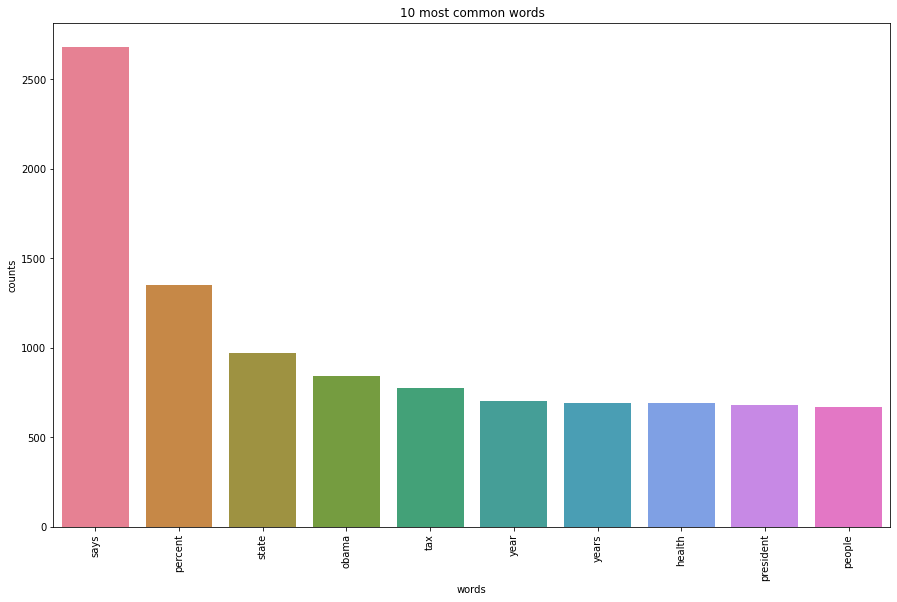

In [0]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Says is the word used in many topicsm which is folllowed by percent and state

In [0]:
processed_docs = liar['CleanStatement'].map(lambda doc: doc.split(" "))

In [0]:

#Function to get tokens of document
def get_tokens(text):
    token = []
    for tk in gensim.utils.simple_preprocess(text):
        if len(tk) > 3:
            token.append(tk)
    return token

In [0]:
tokenized_docs = liar['CleanStatement'].map(get_tokens)

In [0]:

# Function to get dictionary
def get_dictionary(processed_docs):
    dict_gensim = gensim.corpora.Dictionary(processed_docs)
    dict_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dict_gensim

# Function to get Bag of Words
def get_bow_corpus(processed_docs, tokenized_docs):
    dict_gensim = get_dictionary(processed_docs)

    bow_corpus = [dict_gensim.doc2bow(doc) for doc in tokenized_docs]
    return bow_corpus

Createing bag of words and then creating a corpus and calculating LDA score

In [0]:
dictionary = get_dictionary(processed_docs)
bow_corpus = get_bow_corpus(processed_docs, tokenized_docs)

In [0]:

# Running LDA using Bag of Words on train dataset
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [0]:

# Checking the topics and words
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"says" + 0.021*"years" + 0.019*"state" + 0.017*"year" + 0.016*"percent" + 0.015*"last" + 0.014*"jobs" + 0.013*"republican" + 0.009*"illegal" + 0.009*"people"
Topic: 1 
Words: 0.034*"says" + 0.015*"year" + 0.015*"billion" + 0.013*"would" + 0.013*"state" + 0.012*"states" + 0.010*"security" + 0.010*"voted" + 0.010*"bill" + 0.009*"health"
Topic: 2 
Words: 0.023*"says" + 0.020*"billion" + 0.014*"year" + 0.014*"people" + 0.011*"state" + 0.009*"million" + 0.009*"even" + 0.008*"dollars" + 0.008*"medicare" + 0.007*"president"
Topic: 3 
Words: 0.018*"percent" + 0.018*"state" + 0.015*"health" + 0.012*"years" + 0.012*"care" + 0.010*"says" + 0.009*"budget" + 0.009*"every" + 0.008*"jobs" + 0.008*"country"
Topic: 4 
Words: 0.042*"obama" + 0.032*"percent" + 0.028*"says" + 0.025*"president" + 0.024*"barack" + 0.011*"since" + 0.011*"states" + 0.009*"united" + 0.008*"election" + 0.008*"bill"
Topic: 5 
Words: 0.021*"says" + 0.019*"clinton" + 0.018*"obama" + 0.017*"million" + 0.015*"

In [0]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.578482449054718	 
Topic: 0.048*"says" + 0.033*"health" + 0.033*"care" + 0.018*"jobs" + 0.016*"million" + 0.015*"president" + 0.013*"bill" + 0.012*"obama" + 0.012*"would" + 0.010*"taxes"

Score: 0.20615828037261963	 
Topic: 0.037*"says" + 0.026*"percent" + 0.020*"state" + 0.016*"million" + 0.015*"budget" + 0.014*"scott" + 0.014*"states" + 0.013*"wisconsin" + 0.012*"texas" + 0.012*"first"

Score: 0.14534200727939606	 
Topic: 0.042*"obama" + 0.032*"percent" + 0.028*"says" + 0.025*"president" + 0.024*"barack" + 0.011*"since" + 0.011*"states" + 0.009*"united" + 0.008*"election" + 0.008*"bill"

Score: 0.01000351645052433	 
Topic: 0.034*"says" + 0.015*"year" + 0.015*"billion" + 0.013*"would" + 0.013*"state" + 0.012*"states" + 0.010*"security" + 0.010*"voted" + 0.010*"bill" + 0.009*"health"

Score: 0.010003063827753067	 
Topic: 0.023*"says" + 0.020*"billion" + 0.014*"year" + 0.014*"people" + 0.011*"state" + 0.009*"million" + 0.009*"even" + 0.008*"dollars" + 0.008*"medicare" + 0.007*"

In [0]:
liar['LDA_Score'] = score

# Amalgamation with LDA Distillation

In [0]:
liar

label  ... LDA_Score
0     false        ...  0.010001
1     half-true    ...  0.010001
2     mostly-true  ...  0.010001
3     false        ...  0.010001
4     half-true    ...  0.010001
...         ...    ...       ...
1262  half-true    ...  0.010001
1263  barely-true  ...  0.010001
1264  barely-true  ...  0.010001
1265  barely-true  ...  0.010001
1266  false        ...  0.010001

[11507 rows x 20 columns]

In [0]:
liar_clean=liar[['barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','stance','LDA_Score','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)

### Running models to predict fakeness



1.   Checking the gini score to get importance of each factor towards fakeness
2.   Perforiming ML models to predict fakeness



In [0]:
dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_

array([0.17401461, 0.13254912, 0.13420776, 0.09377446, 0.11337697,
       0.13396271, 0.07129593, 0.08056657, 0.06625187, 0.        ])

### Running models to predict fakeness



1.   Checking the gini score to get importance of each factor towards fakeness
2.   Perforiming ML models to predict fakeness



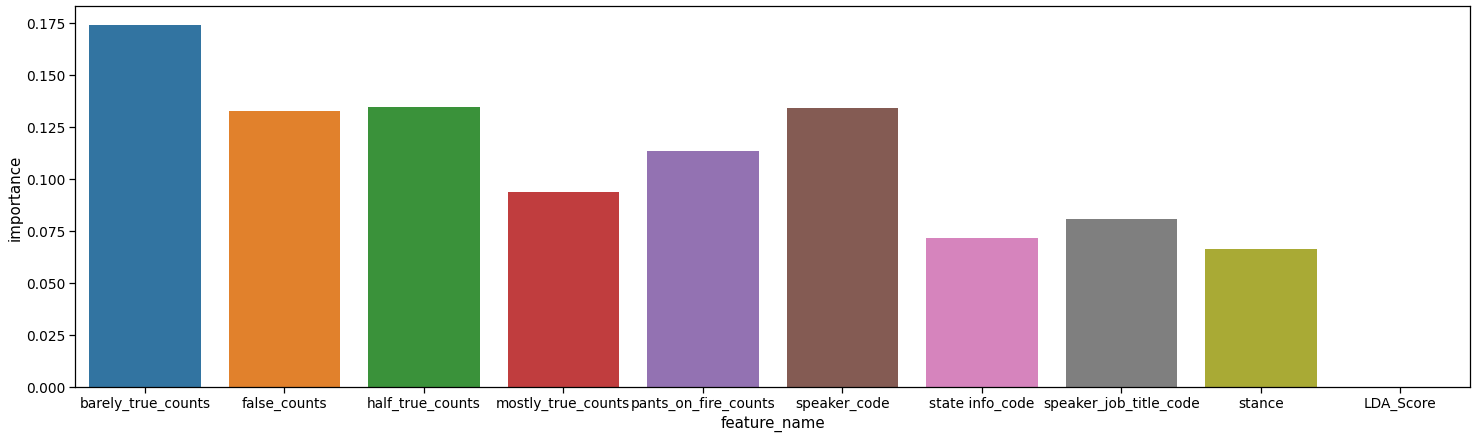

In [0]:
importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(25,7))
sns.barplot(importance.feature_name,importance.importance);

This was a strange discovery LDA score has 0% importance in the fakeness

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 434 243 417  11   0]
 [  5 656 222 428  37   0]
 [  1 417 431 614   6   0]
 [  0 320 303 652   8   0]
 [  2 281  84 130  72   0]
 [  1 330 260 528   8   0]]
Accuracy :  26.28530050687907
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.31      0.00      0.01      1109
           1       0.27      0.49      0.35      1348
           2       0.28      0.29      0.29      1469
           3       0.24      0.51      0.32      1283
           4       0.51      0.13      0.20       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.26      6905
   macro avg       0.27      0.24      0.19      6905
weighted avg       0.25      0.26      0.21      6905

*********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

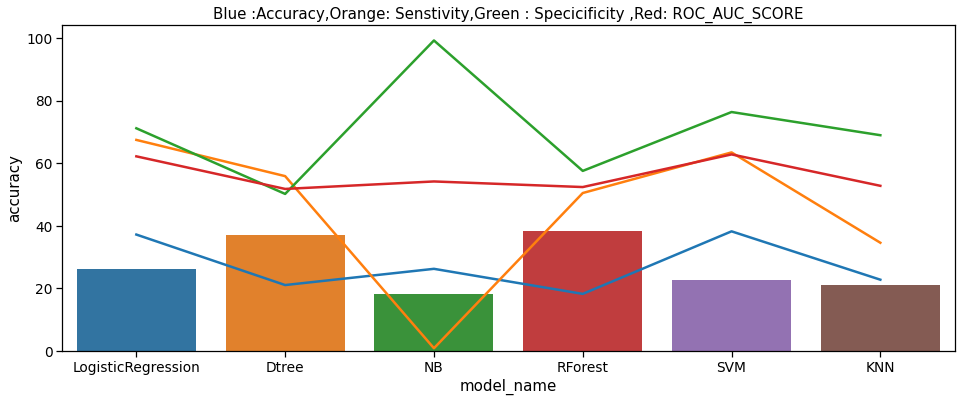

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

After including LDA score there was almost no increase in the accuracy, the reason was LDA has 0% effect on fakeness from gini scores

# Performing Distillation2 : Sentiment Scores

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
def getCompundScore(sentence):
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(sentence)
  return ss['compound']

def getNegScore(sentence):
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(sentence)
  return ss['neg']

def getNeuScore(sentence):
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(sentence)
  return ss['neu']

def getPosScore(sentence):
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(sentence)
  return ss['pos']

In [0]:
liar['compound_score'] = liar['statement'].map(lambda x: getCompundScore(x))
liar['negative_score'] = liar['statement'].map(lambda x: getNegScore(x))
liar['positve_score']   = liar['statement'].map(lambda x: getNeuScore(x))
liar['neutral_score'] = liar['statement'].map(lambda x: getPosScore(x))

# Amalgamating Sentiment Scores with Liar Liar Dataset

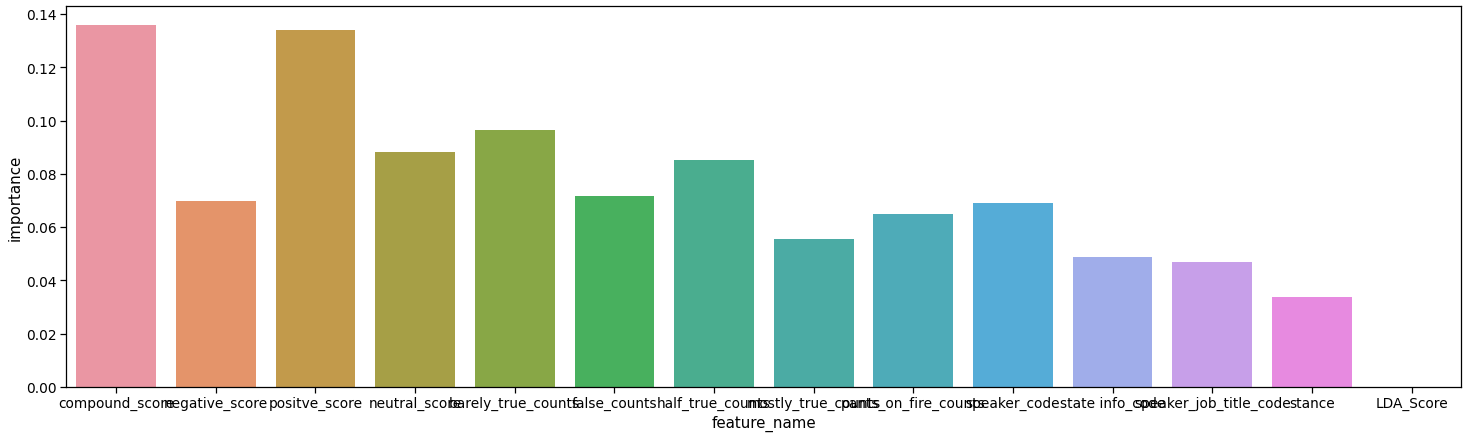

In [0]:
liar_clean=liar[['compound_score','negative_score','positve_score','neutral_score','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','stance','LDA_Score','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)


dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_


importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(25,7))
sns.barplot(importance.feature_name,importance.importance);

Newly added scores of sentiments have decent gini score towards fakeness. Looks like compound statements an dpostive statement have higher effect of Fakeness. That i speople tend to talk more fake information in postive / compound tones

In [0]:
models_dict={}
models_dict['LogisticRegression']       = LogisticRegression()
models_dict['Dtree']                    = DecisionTreeClassifier(criterion='gini')
# models_dict['NB']                       = MultinomialNB()
models_dict['RForest']                  = RandomForestClassifier()
models_dict['SVM']                      = SVC(gamma='auto')
models_dict['KNN']                      = KNeighborsClassifier()

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 412 281 401  11   0]
 [  5 631 256 419  37   0]
 [  1 396 481 585   6   0]
 [  0 286 355 634   8   0]
 [  2 268 103 123  73   0]
 [  1 307 295 515   9   0]]
Accuracy :  26.401158580738592
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.31      0.00      0.01      1109
           1       0.27      0.47      0.35      1348
           2       0.27      0.33      0.30      1469
           3       0.24      0.49      0.32      1283
           4       0.51      0.13      0.20       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.26      6905
   macro avg       0.27      0.24      0.20      6905
weighted avg       0.25      0.26      0.21      6905

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

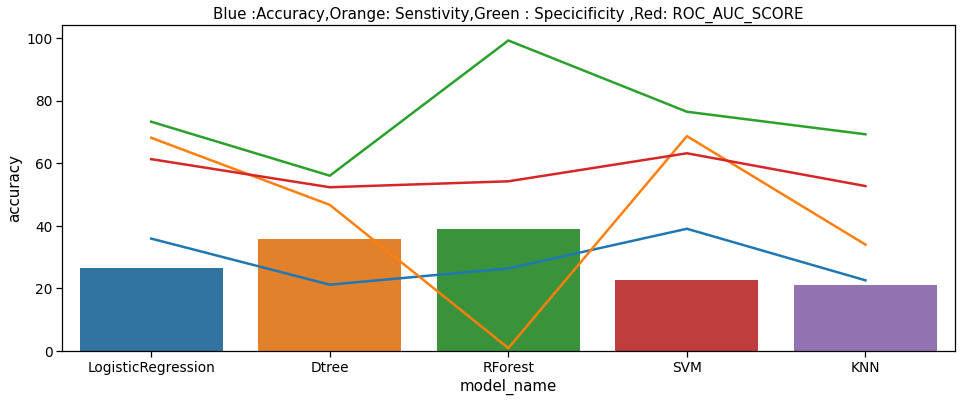

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

Adding new Sentiments , we understood the effect on the scores but it has decreased accuracy of the system . And stll Rforest is performing the best 40% odd accuracy for 6 classes

# Performing Distillation3 : Named Entity relations
Will be using statement and title to capture named entity relations . And use the scores to predict fakeness

In [0]:
import spacy
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
def generate_ner(text):
    doc = nlp(text)
    return [str(chunk) for chunk in doc.noun_chunks] + [str(token) for token in doc if token.pos_ == "VERB"]

def generate_ner_verb(text):
    doc = nlp(text)
    return [str(token) for token in doc if token.pos_ == "VERB"]

def spacy_similarity(t1,t2):
    doc1 = nlp(t1)
    doc2 = nlp(t2)
    return doc1.similarity(doc2)

In [0]:
import re
def break_subject(text):
  if type(text) is float:
    return []
  import re
  return re.split('; |, |-',text)

In [0]:
from nltk.corpus import wordnet 
def generate_Synonyms(wordlist):
    synonyms = set()
    for i in wordlist:
      if type(i) is not str:
        continue
      for syn in wordnet.synsets(i): 
          for l in syn.lemmas(): 
              synonyms.add(l.name())
    return list(synonyms)

def combineSynonyms(data):
    return ' '.join(data)

In [0]:
liar['finalSubject'] = liar.apply(lambda row: break_subject(row['subject']), axis=1)
liar['noVeStatement'] = liar['CleanStatement'].apply(lambda x: ' '.join(generate_ner(x)))
liar['subjectSynonyms'] = liar.apply(lambda row: generate_Synonyms(row['finalSubject']), axis=1)
liar['subjectSynonyms'] = liar['subjectSynonyms'].apply(lambda x: combineSynonyms(x))
liar['noVeSubject'] = liar['subjectSynonyms'].apply(lambda x: ' '.join(generate_ner(x)))
liar['nerScore'] = liar.apply(lambda x: (spacy_similarity(x.noVeSubject,x.noVeStatement)),axis=1)

# Amalgamating N.E.R with Liar Liar Dataset

In [0]:
liar['nerScore'] = liar.apply(lambda x: (spacy_similarity(x.noVeSubject,x.noVeStatement)),axis=1)

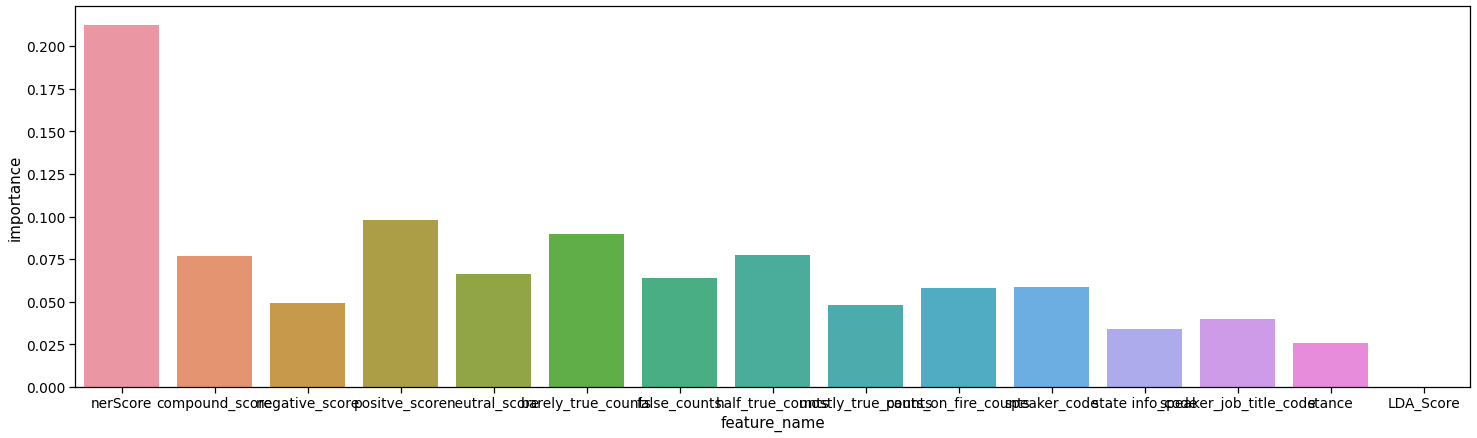

In [0]:
liar_clean=liar[['nerScore','compound_score','negative_score','positve_score','neutral_score','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','stance','LDA_Score','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)


dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_


importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(25,7))
sns.barplot(importance.feature_name,importance.importance);

NER score has the highest effect on fakeness quotient of the news 

In [0]:
models_dict={}
models_dict['LogisticRegression']       = LogisticRegression()
models_dict['Dtree']                    = DecisionTreeClassifier(criterion='gini')
# models_dict['NB']                       = MultinomialNB()
models_dict['RForest']                  = RandomForestClassifier()
models_dict['SVM']                      = SVC(gamma='auto')
models_dict['KNN']                      = KNeighborsClassifier()

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 396 319 379  11   0]
 [  6 626 281 398  37   0]
 [  1 365 553 542   6   2]
 [  0 284 390 599   8   2]
 [  2 272 118 104  72   1]
 [  1 301 328 488   7   2]]
Accuracy :  26.879073135409126
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.29      0.00      0.01      1109
           1       0.28      0.46      0.35      1348
           2       0.28      0.38      0.32      1469
           3       0.24      0.47      0.32      1283
           4       0.51      0.13      0.20       569
           5       0.29      0.00      0.00      1127

    accuracy                           0.27      6905
   macro avg       0.31      0.24      0.20      6905
weighted avg       0.29      0.27      0.21      6905

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

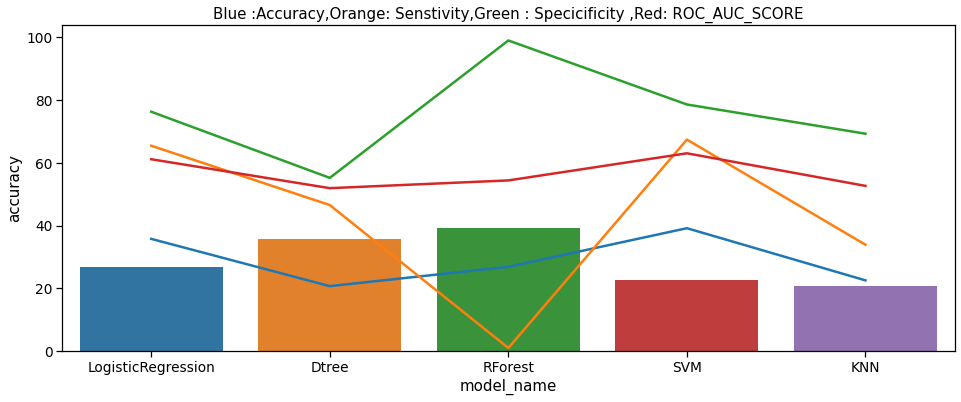

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

Even after the addition of NER , model performances has been almost similar . Rforest performs the best at 40% accuracy

# Performing PCA
## Suspecting the number of dimensions is more hence the accuracy is not changing with more data . Thought of reducing the number of columns by PCA

In [0]:
from sklearn.decomposition import PCA

### After Performing the number of dimensions from 15 was reduced to 5 columns

original shape:    (11507, 15)
transformed shape: (11507, 5)
****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[ 10  38  46  95 102  72]
 [ 15  59  55 120 145  72]
 [  8  56  60 173 108  82]
 [ 12  40  56 162  64  97]
 [  3  27  15  33  88  21]
 [ 14  38  40 122  62  92]]
Accuracy :  20.46046915725456
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.16      0.03      0.05       363
           1       0.23      0.13      0.16       466
           2       0.22      0.12      0.16       487
           3       0.23      0.38      0.29       431
           4       0.15      0.47      0.23       187
           5       0.21      0.25      0.23       368

    accuracy                           0.20      2302
   macro avg       0.20      0.23      0.19      2302
weighted avg       0.21      0.20      0.18      2302

********************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

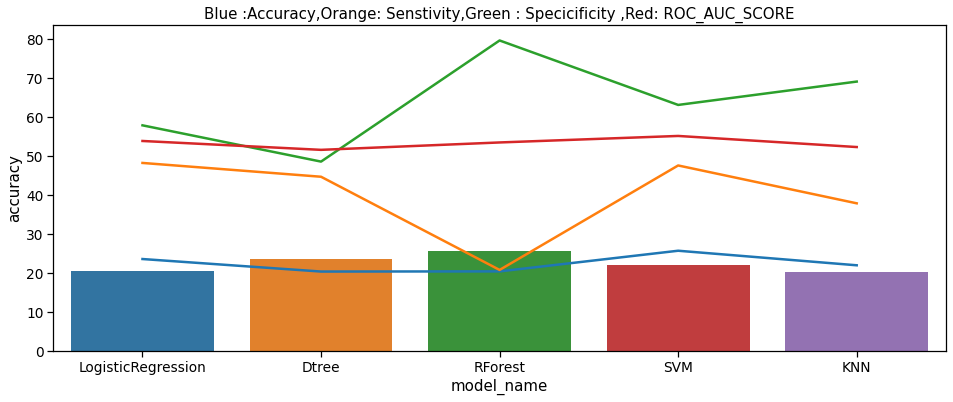

In [0]:
pca = PCA(n_components=0.9999)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

#rerunning all the models again on reduced dimensions
X=pd.DataFrame(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

But to my surprise the accuracy went even in bad shape and max accuracy after PCA is 25% which is really bad

# BERT Transformer

USing TFHUB's BERT transformerto calculate Bert Transformer Score

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

In [0]:
max_seq_length = 512  # Your choice here.

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [0]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))


def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return numerator/float(denominator)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
a=[0]

In [0]:
def getBertScore(s,a):
  a[0]+=1
  stokens = tokenizer.tokenize(s)
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
  input_ids = get_ids(stokens, tokenizer, max_seq_length)
  input_masks = get_masks(stokens, max_seq_length)
  input_segments = get_segments(stokens, max_seq_length)
  pool_embs, all_embs = model.predict([[input_ids],[input_masks],[input_segments]])
  print(a)
  return cosine_similarity(pool_embs[0], all_embs[0][0])

In [0]:
len(liar)

11507

In [0]:
# liar['BertScore'] = liar['CleanStatement'].apply(lambda x:getBertScore(x,a))
# liar.to_csv('liar_with_bert.csv')

In [0]:
link = 'https://drive.google.com/open?id=12RL6JeHXxyZYiDmTeO6o_9dstAF8JhEZ'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar_with_bert.csv')


In [0]:
liar=pd.read_csv('liar_with_bert.csv')

Bert Took almost 4 hours to get BertScore , hence saving the dataset with bert score and will be using this, when collab will be re ran

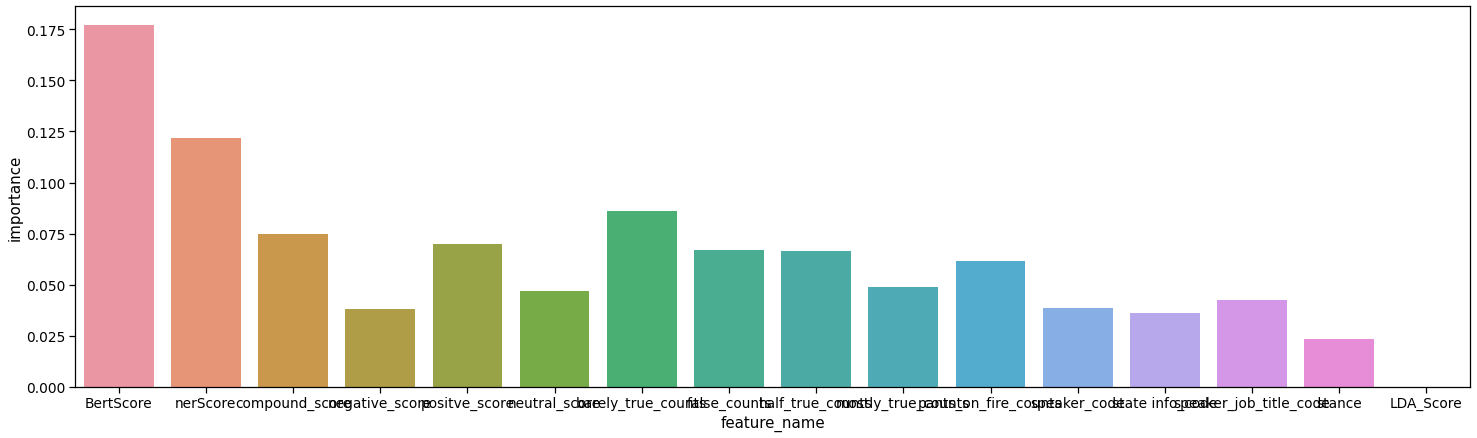

In [0]:
liar_clean=liar[['BertScore','nerScore','compound_score','negative_score','positve_score','neutral_score','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts', 'speaker_code', 'state info_code','speaker_job_title_code','stance','LDA_Score','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)


dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_


importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(25,7))
sns.barplot(importance.feature_name,importance.importance);

Bert Score has the highest gini feature with all the features till now with about 17% importance. Relatively all other columns are less uselfull

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  4 325 432 337  11   0]
 [  6 486 468 351  37   0]
 [  1 315 653 494   6   0]
 [  0 256 493 526   8   0]
 [  2 227 188  80  72   0]
 [  1 236 463 420   7   0]]
Accuracy :  25.213613323678498
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.29      0.00      0.01      1109
           1       0.26      0.36      0.30      1348
           2       0.24      0.44      0.31      1469
           3       0.24      0.41      0.30      1283
           4       0.51      0.13      0.20       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.25      6905
   macro avg       0.26      0.22      0.19      6905
weighted avg       0.24      0.25      0.20      6905

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

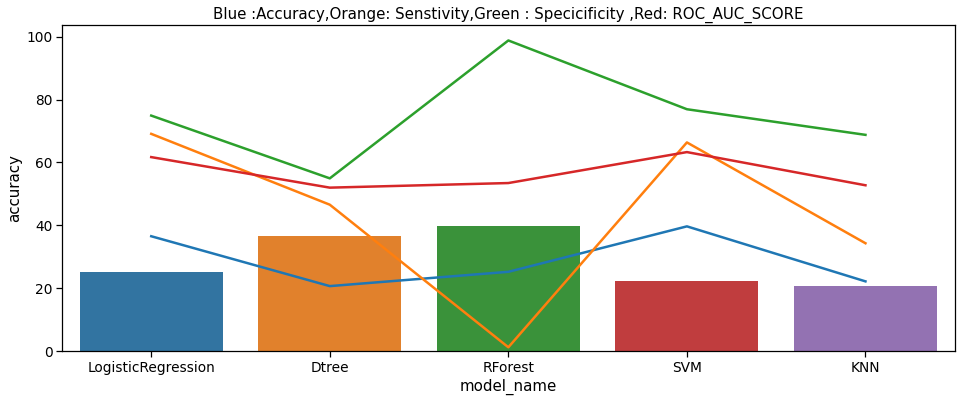

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

# Using GINI scores and picking only top features 

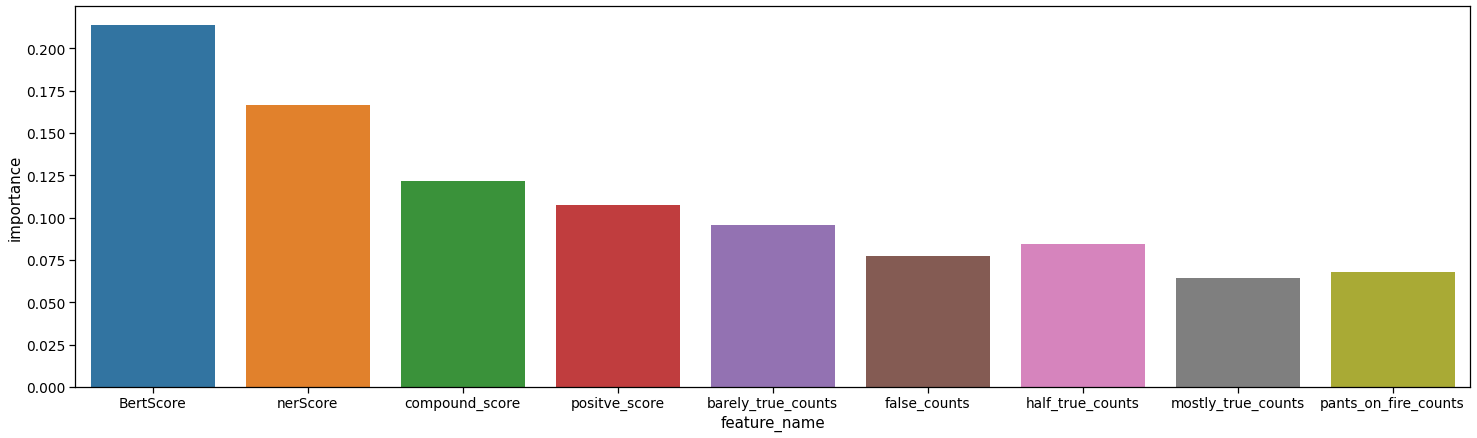

In [0]:
liar_clean=liar[['BertScore','nerScore','compound_score','positve_score','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts','label_code']]
liar_clean=liar_clean.fillna(0)
X=liar_clean.loc[:,liar_clean.columns!='label_code']
Y=liar_clean.loc[:,liar_clean.columns=='label_code']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=1)


dTree= DecisionTreeClassifier(criterion='gini')
dTree.fit(X_train,y_train)
y_pred=dTree.predict(X_test)
accuracy_score(y_test,y_pred)*100
dTree.feature_importances_


importance=pd.DataFrame(X_train.columns)
importance['importance']=dTree.feature_importances_
importance.columns=['feature_name','importance']
plt.figure(figsize=(25,7))
sns.barplot(importance.feature_name,importance.importance);

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[149 139 393 418  10   0]
 [112 615 280 306  35   0]
 [145 140 840 337   7   0]
 [104 161 218 793   7   0]
 [ 61 179 131 121  77   0]
 [ 77 253 341 452   4   0]]
Accuracy :  35.829109341057205
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.23      0.13      0.17      1109
           1       0.41      0.46      0.43      1348
           2       0.38      0.57      0.46      1469
           3       0.33      0.62      0.43      1283
           4       0.55      0.14      0.22       569
           5       0.00      0.00      0.00      1127

    accuracy                           0.36      6905
   macro avg       0.32      0.32      0.28      6905
weighted avg       0.30      0.36      0.31      6905

********************************************************************************************

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

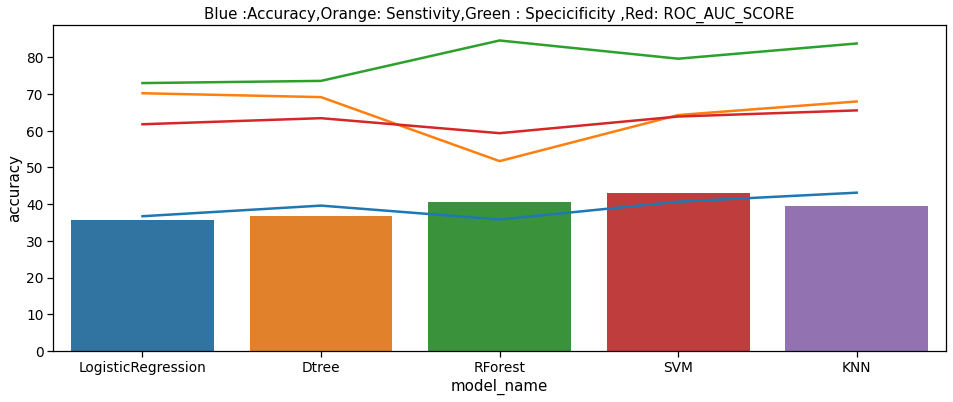

In [0]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

After distillation and amalgamation , with BERT score, NER score , Sentiment Scores 3% accuracy was increased. SVM is giving an accuracy of 43.14 % and almost all other models are giving 40% increase.



# Combining Factors of team members

|Features  |  Member |
|-----|-----|
| Stance Model                 |  Chetan Kulkarni | 
| Political Affiliation                         |  Nupur Yadav |  
| Title Vs Body                   |  Lokesh Vadlamudi  |  
|   Network Factor                           |  Ronak Mehta 



In [1]:
#Importing required libraries
import warnings
warnings.filterwarnings("ignore")

!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from fastai import *
from fastai.tabular import *



import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

# NLTK libraries
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import re

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import joblib

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2.2.0


## Political Affiliation

In [0]:
def FourReal_getPartyAffiliationScore(statement, speaker_job_title, state_info, context): # return between 1 and 6, being 1 = true,  6 = pants-fire
  if ( (statement == "") | (speaker_job_title == "") | (state_info == "") | (context == "")):
    return 0

  #loading the doc2vec model from drive to generate embeddings for statement
  link = 'https://drive.google.com/open?id=1G0GC1VT5ogKyUcMSbdpivDVtPV6Lhheq'
  fluff, id = link.split('=')
  
  #downloading the doc2vec model
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('doc2vec_model.sav')
  d2vmodel = pickle.load(open('doc2vec_model.sav', 'rb'))
  
  statement_wordvec = [d2vmodel.infer_vector(word_tokenize(statement))]
  
  #creating the dataframe with our statement embeddings and other categorical columns 
  #to get a party affiliation probability vector for our final prediction
  df = pd.DataFrame(statement_wordvec)
  df['speaker_job_title']= speaker_job_title
  df['state_info'] = state_info
  df['context'] = context
  df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9', 'speaker_job_title', 'state_info', 'context']
      
  #Loading our NN model to get party affiliation probability vector
  link = 'https://drive.google.com/open?id=1i3TknJOHp-kxUuqL9S2nX1jb-3EQVo5F'
  fluff, id = link.split('=')
  
  #downloading the NN model
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('export.pkl')
  NN_model = load_learner('/content')

  pred = NN_model.predict(df.iloc[0])
  pf_pred = pred[0] 
  pf_probability_vector = pred[2] #party affiliation probability vector

  #creating dataframe for our final prediction between 1-6
  #converting vector to dataframe columns
  v = []
  for i in pf_probability_vector:
    a = float(i)
    v.append(a)

  columns = ['Prob_republican','Prob_democrat', 'Prob_other']
  final_df = pd.DataFrame(v).transpose()
  final_df.columns = columns

  #Loading LR model to make final prediction where a statement lies between 1-6 with 1 being true and 6 being pants-fire
  link = 'https://drive.google.com/open?id=1CaBMxljH5Z7FVXude4btyb5KWGoHNDZ2'
  fluff, id = link.split('=')
  
  #downloading the doc2vec model
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('LogisticRegression.pkl')
  pa_model = joblib.load('LogisticRegression.pkl')

  predicted = pa_model.predict(final_df)
  # predicedProb = pa_model.predict_proba(final_df)[:,1]
  predicedProb=pa_model.predict_proba(final_df)
  return predicedProb.tolist()[0]     #returns probability vector from 1 to 6, with 1 being true and 6 being pants-fire

## Title VS Body

In [0]:
link = 'https://drive.google.com/open?id=1r2LPuNUKy_qMlLzfDnIVdeVZfZrpOngF'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('lokiXgb.pkl')
xgbLoki = joblib.load(open('lokiXgb.pkl', 'rb'))

link = 'https://drive.google.com/open?id=1qoqFk7BU_OCMroq_vvcdWDGzm8w-VDmk'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('party.pkl')
party = joblib.load(open('party.pkl', 'rb'))


def predict_tVsBScore(title,body):
    # import string
    # from nltk.stem import WordNetLemmatizer
    # from nltk.tokenize import RegexpTokenizer
    # from nltk.corpus import stopwords
    # nltk.download('stopwords')
    # from nltk.stem.porter import PorterStemmer


    stemming = PorterStemmer()
    lemma = WordNetLemmatizer()
    def cleanUp(data):
        data = "".join([i for i in str(data) if i not in string.punctuation])
        tokenizer = RegexpTokenizer(r'\w+')
        data = tokenizer.tokenize(data.lower())
        data = [i for i in data if i not in stopwords.words('english')]
        data = [lemma.lemmatize(i) for i in data]
        data = " ".join([stemming.stem(i) for i in data])
        # print(data)
        return data

    # import re
    def break_subject(text):
        if type(text) is float:
          return []
        import re
        a = re.split('; |, |-',text)
        # print(a)
        return re.split('; |, |-',text)

    cleanedBody = cleanUp(body)
    subject = break_subject(title)

    from nltk.corpus import wordnet 
    def generate_Synonyms(wordlist):
        synonyms = set()
        for i in wordlist:
          if type(i) is not str:
            continue
          for syn in wordnet.synsets(i): 
              for l in syn.lemmas(): 
                  synonyms.add(l.name())
        # print(list(synonyms))
        return list(synonyms)
    def combineSynonyms(data):
        return ' '.join(data)
    

    finalSubject = generate_Synonyms(subject)
    # print(finalSubject)
    finalSubject1 = combineSynonyms(finalSubject)
    # print(finalSubject1)

    s = cleanedBody + '@@' + finalSubject1
    # print(s)

    from sklearn.feature_extraction.text import TfidfVectorizer
    # create the transform
    def cosine_sim(statement):
        statement=statement.split('@@')
        # print(statement)
        text1,text2=statement[0],statement[1]
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf = vectorizer.fit_transform([text1, text2])
        sim_score=((tfidf * tfidf.T).A)[0,1]
        pred_label = 0
        if sim_score*100>20:
          pred_label = 1
          
        # if sim_score*100>0:
        #   return 1
        return sim_score , pred_label

    import spacy
    
    # Load English tokenizer, tagger, parser, NER and word vectors
    nlp = spacy.load('en')
    def spacy_similarity(t1,t2):
        doc1 = nlp(t1)
        doc2 = nlp(t2)
        return doc1.similarity(doc2)

    
    simScore , label = cosine_sim(s)
    simScore2 = spacy_similarity(cleanedBody,finalSubject1)
    
    return label,simScore2


def FourReal_TitleVsBody(title,statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,party_affiliation):
  # cosineSim = predict_tVsBScore(title,statement)
      party_affiliation_transform = party.transform([party_affiliation])
      
      df=pd.DataFrame([barely_true_counts])
      df.columns=['barely_true_counts']
      df['false_counts']=false_counts
      df['half_true_counts']=half_true_counts
      df['mostly_true_counts']=mostly_true_counts
      df['pants_on_fire_counts']=pants_on_fire_counts
      df['party affiliation']=party_affiliation_transform
      a,df['cosineSim']=predict_tVsBScore(title,statement)
      
      # barely_true_counts	false_counts	half_true_counts	mostly_true_counts	pants_on_fire_counts	party affiliation	cosineSim	label
      
      prediction = xgbLoki.predict(df)
      prediction_probability = xgbLoki.predict_proba(df)
      return prediction_probability.tolist()[0]

## Network

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=1OckRQ_VK1Ljrabnn9J9x7q3x95Du2Vb_'
fluff, id = link.split('=')
# Download the tsv file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model.hdf5')


def FourReal_getNetwordBasedScore(text):
  text = re.sub("[^a-zA-Z]", " ", str(text))
  text =  text.lower()
  text_words = nltk.word_tokenize(text)
  stops = set(nltk.corpus.stopwords.words("english"))
  words = [w for w in  text_words  if not w in stops]
  wordnet_lem = [WordNetLemmatizer().lemmatize(w) for w in words ]
  stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
  text = " ".join(stems)
  model = tf.keras.models.load_model('model.hdf5')
  tokenizer = Tokenizer(num_words=300, lower=True)
  tokenizer.fit_on_texts(text)
  test_sequences = tokenizer.texts_to_sequences(text)
  test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=300)
  result = model.predict_classes(test_padded_sequences)
  true,fake = 0,0
  total_occurrences = np.size(result)
  for i in result:
    if i==0:
      true+=1
    else:
      fake+=1
  value = fake/total_occurrences
  if value<=0.167:
    return [0,0,0,0,0,1]
  elif value>0.167 and value<=0.334:
    return [0,0,0,0,1,0]
  elif value>0.334 and value<=0.501:
    return [0,0,0,1,0,0]
  elif value>0.501 and value<=0.668:
    return [0,0,1,0,0,0]
  elif value>0.668 and value<=0.835:
    return [0,1,0,0,0,0]
  else:
    return [1,0,0,0,0,0]
  # print("Probability of text being true:",(true/total_occurrences),"Probability of text being fake:",(fake/total_occurrences))

## Stance

In [12]:
from sklearn.externals import joblib 
import re

!pip install nltk
import nltk


nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords


from nltk.tokenize import word_tokenize
import pandas as pd


link = 'https://drive.google.com/open?id=1Gct0uLHt2x6jVt1SmcqlyyLPGhZu_Hfe'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('le_speaker_job_title_code.pkl')

link = 'https://drive.google.com/open?id=1pOEibOMRmNSHUZIHm0wdJfp3SgHRQ4Q2'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('le_speaker.pkl')

link = 'https://drive.google.com/open?id=1EqvpovqAxnKlu50oQCj_ryVF5fOxtilW'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('RForest.pkl')

link = 'https://drive.google.com/open?id=1Wb8JEYXqYcifnTsMgamv8HaCzP_Vvxp2'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('le_state_info_code.pkl')

link = 'https://drive.google.com/open?id=1-SjP9druNndPShP9fSmtibvWel0FGgqP'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('vectorizer.pkl')

link = 'https://drive.google.com/open?id=1iY7WghgNCFq8EYStlYNlqqFuRADpjsGa'
fluff, id = link.split('=')

#downloading the doc2vec model
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('XGB.pkl')

vector=joblib.load('vectorizer.pkl')
loaded_model=joblib.load('XGB.pkl')

le_speaker=joblib.load('le_speaker.pkl')
le_speaker_job_title_code=joblib.load('le_speaker_job_title_code.pkl')
le_state_info_code=joblib.load('le_state_info_code.pkl')
model=joblib.load('XGB.pkl')

stop_words = set(stopwords.words('english')) 
vector=joblib.load('vectorizer.pkl')
loaded_model=joblib.load('RForest.pkl')
def get_stance(statement):
  p_statement= re.sub(r"\W", " ",str(statement))
  p_statement=re.sub(r'[,\.!?]', " ",str(p_statement))
  p_statement=re.sub(r" \d+", " ",str(p_statement))
  p_statement=word_tokenize(p_statement.lower())
  p_statement=' '.join(p_statement)
  p_statement=' '.join([word for word in p_statement.split() if word not in stop_words])
  liar_x = vector.transform([p_statement,])
  stance=loaded_model.predict(liar_x)
  return stance[0]

def FourReal_getStanceScore(statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,speaker,state_info,speaker_job_title):
  speaker_job_title=le_speaker_job_title_code.transform([speaker_job_title])
  speaker=le_speaker.transform([speaker])
  state_info=le_state_info_code.transform([state_info])
  df=pd.DataFrame([barely_true_counts])
  df.columns=['barely_true_counts']
  df['false_counts']=false_counts
  df['half_true_counts']=half_true_counts
  df['mostly_true_counts']=mostly_true_counts

  df['pants_on_fire_counts']=pants_on_fire_counts
  df['Stance']=get_stance(statement)
  df['speaker_code']=speaker
  df['state info_code']=state_info
  df['speaker_job_title_code']=speaker_job_title
 
  # X=np.array(barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,Stance,speaker,speaker_job_title,state_info)
  # ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'Stance', 'speaker_code', 'state info_code', 'speaker_job_title_code'] 
  # ['barely_true_counts', 'pants_on_fire_counts', 'speaker_code', 'mostly_true_counts', 'Stance', 'half_true_counts', 'false_counts', 'state info_code', 'speaker_job_title_code']
  prediction=model.predict(df)
  prediction_probability=model.predict_proba(df)
  return prediction_probability.tolist()[0]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Final Combined Model using normalized accuracies as weights in plynomial equation**

**Since, we are doing a multiclass classification, each of our individual models are generating six probabilities scores for 1 to 6 (1 being true and 6 being pants-fire) class labels and then we are doing a Normslised average for every probability and at last returning the max probability with the corresponding index denoting a label from 1-6 (here indices from 0 to 5).**

In [0]:
def isFakeNewsNormalised(statement,subject,speaker_job_title,state_info,context,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,speaker,party_affiliation):
  accur = [0.45,0.43,0.43,0.95] # using the (normalized) accuracy as weigths
  w = [float(i)/sum(accur) for i in accur]
  sumW = 0
  prob = []
  if ( (statement != "") & (speaker_job_title != "") & (state_info != "") & (context != "")):
    a1,b1,c1,d1,e1,f1 =  FourReal_getPartyAffiliationScore(statement, speaker_job_title, state_info, context)

  if ((statement != "") & (subject != "")):
    a2,b2,c2,d2,e2,f2 =  FourReal_TitleVsBody(subject,statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,party_affiliation)
    
  if (statement!='' and barely_true_counts!='' and false_counts!='' and half_true_counts!='' and mostly_true_counts!='' and  pants_on_fire_counts!='' and speaker!='' and state_info!='' and speaker_job_title!=''):
    a3,b3,c3,d3,e3,f3 =  FourReal_getStanceScore(statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,speaker,state_info,speaker_job_title)
    
  if (statement != ""):
    a4,b4,c4,d4,e4,f4 =  FourReal_getNetwordBasedScore(statement)


  A1=a1*w[0]+a2*w[1]+a3*w[2]+a4*w[3] /sum(accur)
  A2=b1*w[0]+b2*w[1]+b3*w[2]+b4*w[3] /sum(accur)
  A3=c1*w[0]+c2*w[1]+c3*w[2]+c4*w[3] /sum(accur)
  A4=d1*w[0]+d2*w[1]+d3*w[2]+d4*w[3] /sum(accur)
  A5=e1*w[0]+e2*w[1]+e3*w[2]+e4*w[3] /sum(accur)
  A6=f1*w[0]+f2*w[1]+f3*w[2]+f4*w[3] /sum(accur)

  prob_list = [A1,A2,A3,A4,A5,A6]
  prob_max = max(prob_list)
  label = prob_list.index(prob_max)

  return label


## **Final Combined Model using Weighted Average accuracies as weights in plynomial equation**

**Since, we are doing a multiclass classification, each of our individual models are generating six probabilities scores for 1 to 6 (1 being true and 6 being pants-fire) class labels and then we are doing a weighted average for every probability and at last returning the max probability with the corresponding index denoting a label from 1-6 (here indices from 0 to 5).**

In [0]:
def isFakeNewsWeighted(statement,subject,speaker_job_title,state_info,context,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,speaker,party_affiliation):
  accur = [0.43,0.42,0.42,0.94] # using the weighted average as weigths
  w = [float(i)/sum(accur) for i in accur]
  sumW = 0
  prob = []
  if ( (statement != "") & (speaker_job_title != "") & (state_info != "") & (context != "")):
    a1,b1,c1,d1,e1,f1 =  FourReal_getPartyAffiliationScore(statement, speaker_job_title, state_info, context)

  if ((statement != "") & (subject != "")):
    a2,b2,c2,d2,e2,f2 =  FourReal_TitleVsBody(subject,statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,party_affiliation)
    
  if (statement!='' and barely_true_counts!='' and false_counts!='' and half_true_counts!='' and mostly_true_counts!='' and  pants_on_fire_counts!='' and speaker!='' and state_info!='' and speaker_job_title!=''):
    a3,b3,c3,d3,e3,f3 =  FourReal_getStanceScore(statement,barely_true_counts,false_counts,half_true_counts,mostly_true_counts, pants_on_fire_counts,speaker,state_info,speaker_job_title)
    
  if (statement != ""):
    a4,b4,c4,d4,e4,f4 =  FourReal_getNetwordBasedScore(statement)


  A1=a1*w[0]+a2*w[1]+a3*w[2]+a4*w[3] /sum(accur)
  A2=b1*w[0]+b2*w[1]+b3*w[2]+b4*w[3] /sum(accur)
  A3=c1*w[0]+c2*w[1]+c3*w[2]+c4*w[3] /sum(accur)
  A4=d1*w[0]+d2*w[1]+d3*w[2]+d4*w[3] /sum(accur)
  A5=e1*w[0]+e2*w[1]+e3*w[2]+e4*w[3] /sum(accur)
  A6=f1*w[0]+f2*w[1]+f3*w[2]+f4*w[3] /sum(accur)

  prob_list = [A1,A2,A3,A4,A5,A6]
  prob_max = max(prob_list)
  label = prob_list.index(prob_max)

  return label


In [23]:
result = isFakeNewsNormalised("Hillary Clinton agrees with John McCain by voting to give George Bush the benefit of the doubt on Iran","foreign-policy","President","Illinois","Denver",70,71,160,163,9,'barack-obama','democrat')
print("Result is :", result)

result = isFakeNewsWeighted("Hillary Clinton agrees with John McCain by voting to give George Bush the benefit of the doubt on Iran","foreign-policy","President","Illinois","Denver",70,71,160,163,9,'barack-obama','democrat')
print("Result is :", result)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Result is : 2
Result is : 2


**Using both methods : accuracies and weighted average,  gave same results for final inference model which is '2' meaning 'half-true'**

# Conclusion



|Technique  |  Best Model | Accuracy
|-----|-----|------|
| Without Amalgamation, using features from base liar dataset  |  XG Boost |  42%
| With Amalgamation of Stance using derived FakeNews and Stance2Eval Dataset  |  Random Forest |  37.5%
|With Amalgamation + LDA score | Random Forest                    |  38.26%
|With Amalgamation + Stance +  LDA score + Sentiment score | Random Forest              |  39.27%
|With Amalgamation + Stance + LDA score + Sentiment Score + NER score          | Random Forest | 39.18%%
| PCA on above features (15 features to 5 PCA) | Random Forest  |  25% | 
|Applying BERT Transformer   | Random Forest  |  39.66% | 
Using top features dervied from Gini on above created dataset | SVM  |  44% | 



---
With The Base liar liar Dataset, Multiclass Classification resulted in 42%. I Started adding Amalgamation and different Features.

|Effect of new Feature to fakeness prediction |
|-----|
|1.  Stance Had some effect of fakeness |
|2.  LDA had absolutely no effect on Fakeness|
|3.  Sentiment Scores - Partivularly Compund Scores and Neutral Scores had Direct effect on fakeness|
|4.  NER had the most effect|
|5.  Using the State of the art BERT transformer, and having a score resulted in the highest effect.|

##With all the above enrichment basic 42% with low sensitivity and specificicty was increased to 44% high sensitivity and specificty.

**Detailed comparision of each step with GINI scores of every factor and relative model performance can be found above**

---

**In the final combined model combining factors from my team members I tried two strategies as follows :**

* Using accuracies as weights in polynomial equation, and
* Using weighted average as weights in plynomial equation.

**Both the stategies predicted the same result for an example statement.** 

|Summarised Process|
|-----|
|1.   Basic LiarLiar dataset we could predict fakeness of multiclass with 37%  Accuracy With Rforest|
|2.   Started with generating Stance as a factor, Stance Proved to have decent effect on fakeness using gini score , But didnt improve the performance of models in any way|
|3.   Did LDA , and calculated LDA score, To my surprise found out that LDA had effect on score  using gini score and that was evident on the [erformance of the models| 
|4.   Performed Sentiment Analysis and calculated various scores of compound,neutral,positve and negative sentiments. These factors actually had a effect on fakeness according gini scores. But yet again model performance did not increase.|
|5.  Performed NER , and found out NER has a better effect than sentiments according gini scores . Model Accuracy was almost similiar for Rforest. But other Model started performing better after inclusion of NER|
|6.  I suspected that with the increase of dimensions, we are facing curse of dimensionality and hence models are performing in a bad way.  I performed PCA and tested Models . PCA reduced 15 columns to mere 20% accuracy.|
|7.  Tried to use statre of the art technique BERT to calculate the BERT score using the prebuilt tensorflow bert. This model ran for about 4 hours|
|8.  Very Surprisingly BERT score had the higesht effect on Fakenss according to Gini score. And models started performing bad. And max accuracy was only 37%.|
|9.  The above result was a bit off, because with more data amalgamation of features that have effect on fakeness, models were performing in a bad way.|
|10. I decided to use only the columns that has top GINI effect scores, and performed model training. We hit the accuracy of 43% with SVM. |
|11. We will be going with SVM to predict fakeness which has accuracy of 43%.|



Using Amalgamation and Distillation Tehniques i could increase the system to have a better accuracy and better sensitivity to the prediction of fakeness